RoBERTa Model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install transformers

(30000, 2)


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Train data shape: (20000, 2)
Test data shape: (5000, 2)
Validation data shape: (5000, 2)


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2606: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
625it [06:50,  1.52it/s]


Train Loss: 0.4095730185508728 Accuracy: 0.8198116987179487


157it [00:32,  4.79it/s]


Test Loss: 0.33346182107925415 Accuracy: 0.8657852564102564


625it [06:49,  1.53it/s]


Train Loss: 0.2935731112957001 Accuracy: 0.8798076923076923


157it [00:32,  4.79it/s]


Test Loss: 0.3263424038887024 Accuracy: 0.8727964743589743


625it [06:49,  1.53it/s]


Train Loss: 0.2364763617515564 Accuracy: 0.909004407051282


157it [00:32,  4.79it/s]


Test Loss: 0.33740416169166565 Accuracy: 0.866386217948718


625it [06:49,  1.53it/s]


Train Loss: 0.18475642800331116 Accuracy: 0.9319911858974359


157it [00:32,  4.77it/s]


Test Loss: 0.41569191217422485 Accuracy: 0.8633814102564102
F1-Score: 0.848728813559322
Accuracy: 0.8572
Confusion Matrix:
[[2283  217]
 [ 497 2003]]


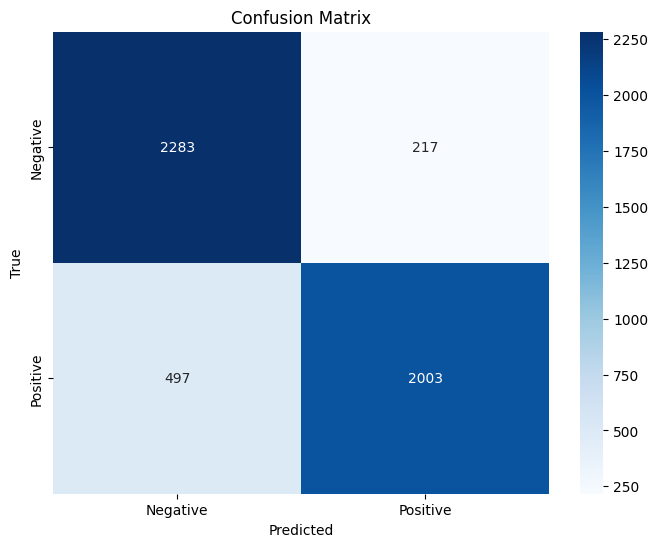

In [ ]:
import torch
from transformers import RobertaModel
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
import numpy as np
import seaborn as sns

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 32
LEARNING_RATE = 1e-05
EPOCHS = 4

# Read the CSV file and specify the appropriate encoding
full_data = pd.read_csv('/content/drive/MyDrive/DataSet/df_small.csv', encoding='latin-1')

# Define the number of samples
NUM_SAMPLES = 15000

# Select the specified number of negative and positive samples
negative_samples = full_data[full_data["label"] == 0].head(NUM_SAMPLES)
positive_samples = full_data[full_data["label"] == 1].head(NUM_SAMPLES)

# Change the label for positive samples to 1
positive_samples["label"] = 1

# Concatenate the positive and negative samples to create the new full_data DataFrame
full_data = pd.concat([negative_samples, positive_samples])

# Check the dimensions of the resulting DataFrame
print(full_data.shape)  # This should now have 30,000 samples with 15,000 positive and 15,000 negative samples

class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.classifier = torch.nn.Linear(768, 2)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids,
                           attention_mask=attention_mask,
                           token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        output = self.classifier(pooler)
        return output

model = RobertaClass()
model.to("cuda:0")

# Shuffle the data
full_data = full_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Define the sizes for each split
total_size = full_data.shape[0]
train_size = 20000
test_size = 5000
valid_size = 5000

# Calculate the number of samples for each label
num_positive_samples = full_data['label'].sum()
num_negative_samples = total_size - num_positive_samples

# Calculate the number of positive and negative samples for each set
train_pos_samples = int(train_size / 2)
train_neg_samples = train_size - train_pos_samples
test_pos_samples = int(test_size / 2)
test_neg_samples = test_size - test_pos_samples
valid_pos_samples = int(valid_size / 2)
valid_neg_samples = valid_size - valid_pos_samples

# Split the data into training, testing, and validation sets with equal labels
train_data = pd.concat([
    full_data[full_data['label'] == 1].head(train_pos_samples),
    full_data[full_data['label'] == 0].head(train_neg_samples)
])

test_data = pd.concat([
    full_data[full_data['label'] == 1].iloc[train_pos_samples:train_pos_samples + test_pos_samples],
    full_data[full_data['label'] == 0].iloc[train_neg_samples:train_neg_samples + test_neg_samples]
])

valid_data = pd.concat([
    full_data[full_data['label'] == 1].iloc[train_pos_samples + test_pos_samples:],
    full_data[full_data['label'] == 0].iloc[train_neg_samples + test_neg_samples:]
])

# Shuffle the data again to randomize the order
train_data = train_data.sample(frac=1, random_state=42).reset_index(drop=True)
test_data = test_data.sample(frac=1, random_state=42).reset_index(drop=True)
valid_data = valid_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Print the shapes of the resulting datasets
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("Validation data shape:", valid_data.shape)

train_data['label'].value_counts()

valid_data['label'].value_counts()

test_data['label'].value_counts()

tokenizer = RobertaTokenizer.from_pretrained('roberta-base',
                                             truncation=True,
                                             do_lower_case=True)
MAX_LEN = 130

train_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in train_data['text']]

test_tokenized_data = [tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=MAX_LEN,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        for text in test_data['text']]

class SentimentData(Dataset):
    def __init__(self, data, inputs_tokenized):
        self.inputs = inputs_tokenized
        self.text = data['text']
        self.targets = data['label']

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        input = self.inputs[index]
        ids = input['input_ids']
        mask = input['attention_mask']
        token_type_ids = input['token_type_ids']

        return {
            'sentence': text,
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

train_dataset = SentimentData(train_data, train_tokenized_data)
test_dataset = SentimentData(test_data, test_tokenized_data)

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': True
                }

train_loader = DataLoader(train_dataset, **train_params)
test_loader = DataLoader(test_dataset, **test_params)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LEARNING_RATE)
train_loss = []
test_loss = []

train_accuracy = []
test_accuracy = []

test_answers = [[[], []], [[], []]]


def train_loop(epochs):
    for epoch in range(epochs):
        for phase in ['Train', 'Test']:
            if (phase == 'Train'):
                model.train()
                loader = train_loader
            else:
                model.eval()
                loader = test_loader
            epoch_loss = 0
            epoch_acc = 0
            for steps, data in tqdm(enumerate(loader, 0)):
                sentence = data['sentence']
                ids = data['ids'].to("cuda:0", dtype=torch.long)
                mask = data['mask'].to("cuda:0", dtype=torch.long)
                token_type_ids = data['token_type_ids'].to("cuda:0", dtype=torch.long)
                targets = data['targets'].to("cuda:0", dtype=torch.long)

                outputs = model.forward(ids, mask, token_type_ids)

                loss = loss_function(outputs, targets)

                epoch_loss += loss.detach()
                _, max_indices = torch.max(outputs.data, dim=1)
                bath_acc = (max_indices == targets).sum().item() / targets.size(0)
                epoch_acc += bath_acc

                if (phase == 'Train'):
                    train_loss.append(loss.detach())
                    train_accuracy.append(bath_acc)
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                else:
                    test_loss.append(loss.detach())
                    test_accuracy.append(bath_acc)
                    if epoch == epochs - 1:
                        for i in range(len(targets)):
                            test_answers[targets[i].item()][max_indices[i].item()].append([sentence[i],
                                                                                          targets[i].item(),
                                                                                          max_indices[i].item()])

            print(f"{phase} Loss: {epoch_loss / steps} Accuracy: {epoch_acc / steps}")


train_loop(EPOCHS)

# Extract true labels and predicted labels
true_labels = []
predicted_labels = []
for label in test_answers[0]:
    true_labels.extend([item[1] for item in label])
    predicted_labels.extend([item[2] for item in label])
for label in test_answers[1]:
    true_labels.extend([item[1] for item in label])
    predicted_labels.extend([item[2] for item in label])

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

# Calculate F1-score, accuracy, and confusion matrix
f1 = f1_score(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)

print("F1-Score:", f1)
print("Accuracy:", accuracy)
print("Confusion Matrix:")
print(confusion)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
